<h1 style="text-align:center">Basic Input Shaping for a<br>Simple Mass-Spring-Damper System</h1>
<p style="text-align:center">Dr. Joshua Vaughan<br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/</p>

<p style="text-align:center">
	<img src="http://shared.crawlab.org/MassSpringDamper_Seismic_Horiz.png" alt="A Mass-Spring-Damper System with a Position Input" width=50%/></a><br>
    <strong> Figure 1: A Mass-Spring-Damper System with a Position Input</strong>
</p>

This notebook simluates a simple mass-spring-damper model like the one shown in Figure 1, to both unshaped and shaped inputs. The system has a position input $y(t)$, and the output is the position of mass, $x(t)$. This system could also be used to model the position control of a mass via a Proportional Derivative (PD) controller. 

The equation of motion for this system is:

$ \quad m\ddot{x} + c \dot{x} + k x = c \dot{y} + k y $

We can also rewrie this in terms of damping ratio, $\zeta$, and natural frequency, $\omega_n$:

$ \quad \ddot{x} + 2 \zeta \omega_n \dot{x} + \omega_n^2 x = \zeta \omega_n \dot{y} + \omega_n^2 y $

However, as we'll see below, we often will collect terms so that our ''motion'' variable are all on the left-hand side, like:

$ \quad \ddot{x} = \frac{k}{m}\left( y - x \right) + \frac{c}{m} \left(\dot{y} - \dot{x} \right) $

For this system, the input is the position and velocity of the spring/damper attachment point, $y(t)$. We could specifiy both of these terms, $y(t)$ and $\dot{y}(t)$, directly. However, if we proceed this way, for every change in desired command, we have to generate both of these terms (and be sure that they correspond correctly). There is also a danger in directly specifying position or velocities. We can easily generate desired trajectories that our system cannot achieve.

Instead, we will specify the acceleration of the connection point and let the solver propagate this command to the velocity and position of the point.

In [1]:
import numpy as np

In [2]:
# We want out plots to show up inline with the notebook
%matplotlib inline 

import matplotlib.pyplot as plt

In [3]:
# Import the ODE solver
from scipy.integrate import odeint

## Functions defining the equations of motion and inputs
We will first define the functions that define the equations of motion and the inputs. As expalined above, tne "trick" that we will use is to define $y(t)$ and $\dot{y}(t)$ as states. This allows us to specifiy an acceleration input $\ddot{y}(t)$, which gets propogated to the $y(t)$ and $\dot{y}(t)$ via the equations of motion (or state-transition matrix if we were solving in "true" matrix-based state-space form).

So, we can then define our states as vector $ \bar{w} = \left[x \ \dot{x} \  y \ \dot{y}\right]^T $ and the inputs as $\bar{u} = \left[\ddot{y} \ f \right]$.

Then the system of first-order ODEs we have to solve is:

$ \quad \dot{\bar{w}} = g(\bar{w}, \bar{u}, t) $

Writing these out, we have:

$ \quad \dot{\bar{w}}  = \left[\dot{x} \right.$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \frac{k}{m}(y - x) + \frac{c}{m}\left(\dot{y} - \dot{x}\right) $

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \dot{y}$

$\phantom{\quad \dot{\bar{w}}  = \left[\right.} \left.\ddot{y}\right]$

Notice that the $\ddot{y}$ in the last line is what we get to specify to generate the position input. In addition to allowing us to only specify one input that gets propograted to y and $\dot{y}$, describing inputs in the acceleration domain is often preferrable. This is because representing a realistic input in this domain is often easier than in the position or velocity domain.

In [4]:
def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    """
    x, x_dot, y, y_dot = w
    m, k, c, Distance, StartTime, Amax, Vmax, Shaper = p

    # Create sysODE = (x', x_dot', y', y_dot')
    sysODE = [x_dot,
             k/m * (y - x) + c/m * (y_dot - x_dot),
             y_dot,
             y_ddot(t, p)]
    return sysODE

def y_ddot(t, p):
    """
    Defines the accel input to the system.
    
    We'll make a call to our lab function accel_input()
    
    Depending on the desired move distance, max accel, and max velocity, the input is either
    bang-bang or bang-coast-bang
    
    Arguments:
        t : current time step 
        p : vector of parameters
    """
    m, k, c, Distance, StartTime, Amax, Vmax, Shaper = p
    
    y_ddot = accel_input(Amax,Vmax,Distance,StartTime,t,Shaper)
    
    return y_ddot

In [5]:
# This cell includes functions to generate the acceleartion input

def accel_input(Amax,Vmax,Distance,StartTime,CurrTime,Shaper):
    """
    # Original MATLAB/Octave premable
    ###########################################################################
    # function [accel] = accel_input(Amax,Vmax,Distance,CurrTime,Shaper)
    #
    # Function returns acceleration at a given timestep based on user input
    #
    # Amax = maximum accel, assumed to besymmetric +/-
    # Vmax = maximum velocity, assumed to be symmetric in +/-
    # Distance = desired travel distance 
    # StartTime = Time command should begin
    # CurrTime = current time 
    # Shaper = array of the form [Ti Ai] - matches output format of shaper functions
    #           in toolbox
    #          * If Shaper is empty, then unshaped is run
    #
    #
    # Assumptions:
    #   * +/- maximums are of same amplitude
    #   * command will begin at StartTime (default = 0)
    #   * rest-to-rest bang-coast-bang move (before shaping)
    #
    # Created: 9/23/11 - Joshua Vaughan - vaughanje@gatech.edu
    #
    # Modified: 
    #   10/11/11
    # 		* Added hard-coded shaping option - JEV (vaughanje@gatech.edu)
    # 		* embedded into shaped_jumping.m for use there
    #
    ###########################################################################
    #
    #
    # Converted to Python on 3/3/13 by Joshua Vaughan (joshua.vaughan@louisiana.edu)
    #
    # Modified:
    #   * 3/26/14 - Joshua Vaughan - joshua.vaughan@louisiana.edu
    #       - Updated some commenting, corrected typos
    #       - Updated numpy import as np
    """

    # These are the times for a bang-coast-bang input 
    t1 = StartTime
    t2 = (Vmax/Amax) + t1
    t3 = (Distance/Vmax) + t1
    t4 = (t2 + t3)-t1
    end_time = t4

    if len(Shaper) == 0:
        # If no shaper is input, create an unshaped command
        if t3 <= t2: # command should be bang-bang, not bang-coast-bang
            t2 = np.sqrt(Distance/Amax)+t1
            t3 = 2.0 * np.sqrt(Distance/Amax)+t1
            end_time = t3
        
            accel = Amax*(CurrTime > t1) - 2*Amax*(CurrTime > t2) + Amax*(CurrTime > t3)
    
        else: # command is bang-coast-bang
            accel = Amax*(CurrTime > t1) - Amax*(CurrTime > t2) - Amax*(CurrTime > t3) + Amax*(CurrTime > t4)

    else: # create a shaped command
        ts = np.zeros((9,1))
        A = np.zeros((9,1))
        # 	Parse Shaper parameters
        for ii in range(len(Shaper)):
            ts[ii] = Shaper[ii,0]  # Shaper impulse times
            A[ii] = Shaper[ii,1]  # Shaper impulse amplitudes

        # Hard-coded for now
        # TODO: be smarter about constructing the total input - JEV - 10/11/11
        accel = (A[0]*(Amax*(CurrTime > (t1+ts[0])) - Amax*(CurrTime > (t2+ts[0])) - Amax*(CurrTime > (t3+ts[0])) + Amax*(CurrTime > (t4+ts[0])))
        +	A[1]*(Amax*(CurrTime > (t1+ts[1])) - Amax*(CurrTime > (t2+ts[1])) - Amax*(CurrTime > (t3+ts[1])) + Amax*(CurrTime > (t4+ts[1])))
        +   A[2]*(Amax*(CurrTime > (t1+ts[2])) - Amax*(CurrTime > (t2+ts[2])) - Amax*(CurrTime > (t3+ts[2])) + Amax*(CurrTime > (t4+ts[2])))
        +   A[3]*(Amax*(CurrTime > (t1+ts[3])) - Amax*(CurrTime > (t2+ts[3])) - Amax*(CurrTime > (t3+ts[3])) + Amax*(CurrTime > (t4+ts[3])))
        +   A[4]*(Amax*(CurrTime > (t1+ts[4])) - Amax*(CurrTime > (t2+ts[4])) - Amax*(CurrTime > (t3+ts[4])) + Amax*(CurrTime > (t4+ts[4])))
        +   A[5]*(Amax*(CurrTime > (t1+ts[5])) - Amax*(CurrTime > (t2+ts[5])) - Amax*(CurrTime > (t3+ts[5])) + Amax*(CurrTime > (t4+ts[5])))
        +   A[6]*(Amax*(CurrTime > (t1+ts[6])) - Amax*(CurrTime > (t2+ts[6])) - Amax*(CurrTime > (t3+ts[6])) + Amax*(CurrTime > (t4+ts[6])))
        +   A[7]*(Amax*(CurrTime > (t1+ts[7])) - Amax*(CurrTime > (t2+ts[7])) - Amax*(CurrTime > (t3+ts[7])) + Amax*(CurrTime > (t4+ts[7])))
        +   A[8]*(Amax*(CurrTime > (t1+ts[8])) - Amax*(CurrTime > (t2+ts[8])) - Amax*(CurrTime > (t3+ts[8])) + Amax*(CurrTime > (t4+ts[8]))))

    return accel


In [6]:
def ZV(f,zeta,deltaT):
    """
    
    This function returns an exact and digitized version of the ZV shaper for 
    natural frequecy, f Hz, and damping ratio, zeta. The exactshaper is digitize for use
    at a shaping ratio of deltaT seconds/sample.
    
    Original MATLAB preamble
        ZV(f,zeta,deltaT) -- Bill Singhose
        Generates a ZV shaper for 1 mode.
        f - frequency (Hz) of vibration being controlled.
        zeta - damping ratio of vibration being controlled.
        deltaT - time spacing at which input to system is updated.
        
        This function generates the exact sequence and then uses
        DigitizeSeq to convert the exact sequence to digital format.
    
    
    Converted to Python on 2/19/13 - Joshua Vaughan - joshua.vaughan@louisiana.edu
    
    Arguments:
      f : frequency to suppress vibraton at (Hz)
      zeta : damping ratio 
      deltaT : The sampling time used in the digial implementation of the shaper
    
    Returns:
      shaper : the digitized version of the shaper
      exactshaper : the exact shaper soltuion in. Impulse times and amplitudes are in 2x2 array
    
    """

    Wn = 2*np.pi*f
    shaperdeltaT = np.pi / (Wn * np.sqrt(1-(zeta)**2))
    K = np.exp(-zeta * np.pi / (np.sqrt(1-zeta**2)))
    shaperdenom  =  1 + K

    time2 = shaperdeltaT   
 
    amp1 = 1.0 / shaperdenom
    amp2 = K / shaperdenom

    exactshaper = np.array([[0.,amp1],[time2,amp2]])
    shaper = digseq(exactshaper,deltaT)

    return shaper, exactshaper



def digseq(seq, step):
    """
    This function digitizes an impulse sequence, seq, so that it will function properly
    for a sampling rate of step seconds/sample.
    
    Original MATLAB preamble
        digseq - Whit Rappole
        DIGITIZESEQ Map a sequence onto digital timing loop
        dseq = digseq(seq,step)
    
        Uses a linear extrapolation to split each continuous
        impulse into two digital impulses
        

    Converted to Python on 2/18/13 by Joshua Vaughan (joshua.vaughan@louisiana.edu)
    """

    dseq = np.zeros((round(seq[-1,0]/step)+2,1))

    for nn in range(len(seq)):
        index = np.floor(seq[nn,0]/step)
        woof = (seq[nn,0]-index*step)/step
        dseq[index+1] = dseq[index+1]+woof*seq[nn,1]
        dseq[index] = dseq[index]+seq[nn,1] - woof*seq[nn,1]

    while dseq[len(dseq)-1] == 0:
        dseq = dseq[0:(len(dseq)-1)]

    return dseq

In [7]:
# Define the parameters for simluation
m = 1.0                      # mass (kg)
k = (0.5*2*np.pi)**2         # spring constant (N/m)

wn = np.sqrt(k/m)            # natural frequency (rad/s)

# Select damping ratio and use it to choose an appropriate c
zeta = 0.0                   # damping ratio
c = 2*zeta*wn*m              # damping coeff.

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.001
stoptime = 5.0
numpoints = 50001

# Create the time samples for the output of the ODE solver
t = np.linspace(0.,stoptime,numpoints)

# Initial conditions
x_init = 0.0                        # initial position
x_dot_init = 0.0                    # initial velocity
y_init = 0.0                        # initial "command" position
y_dot_init = 0.0                    # initial "command" velocity

# Set up the parameters for the input function
Distance = 1.5               # Desired move distance (m)
Amax = 200.0                 # acceleration limit (m/s^2)
Vmax = 1.0                   # velocity limit (m/s)
StartTime = 0.5              # Time the y(t) input will begin

# Design and define an input Shaper  
Shaper = [] # An empty shaper means no input shaping

# Pack the parameters and initial conditions into arrays 
p = [m, k, c, Distance, StartTime, Amax, Vmax, Shaper]
x0 = [x_init, x_dot_init, y_init, y_dot_init]

In [8]:
# Call the ODE solver.
resp_unshaped = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

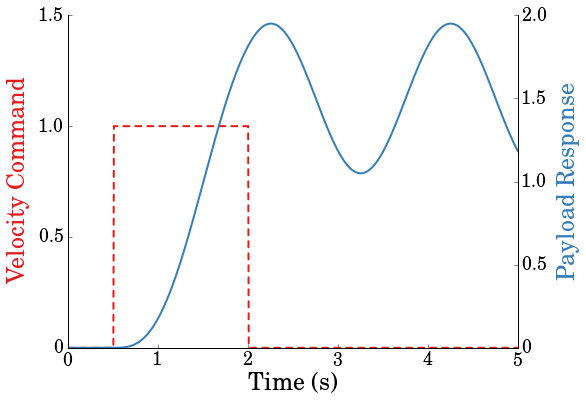

In [9]:
plt.rcParams['axes.grid'] = False # No grids for these dual y plots

# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax1 = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax1.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax1.get_xmajorticklabels(),family='serif',fontsize=18)
# ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# ax1.grid(False,linestyle=':',color='0.75')
ax1.set_axisbelow(True)


plt.xlabel('Time (s)',family='serif',fontsize=24,weight='bold',labelpad=5)
plt.ylabel('Velocity Command',family='serif',fontsize=24, color = '#e41a1c', weight='bold',labelpad=10)

# plot the response
ax1.plot(t,resp_unshaped[:,3], linewidth=2, 
         color = '#e41a1c', linestyle = '--', label=r'Command $(y)$')
plt.ylim(0,1.5)
plt.yticks([0,0.5,1,1.5],['0','0.5','1.0','1.5'])
plt.xticks([0,1,2,3,4,5],['0','1','2','3','4','5'])

ax2 = ax1.twinx()
ax2.spines['top'].set_color('none')
ax2.plot(t,resp_unshaped[:,0], linewidth=2, color = '#377eb8', 
         linestyle = '-', label=r'Response $(x)$')
plt.ylim(0,2)
plt.yticks([0,0.5,1,1.5,2.0],['0','0.5','1.0','1.5','2.0'])
plt.ylabel('Payload Response',family='serif', fontsize=24, color = '#377eb8',weight='bold',labelpad=10)


# leg = legend(loc='lower right', fancybox=True)
# ltext  = leg.get_texts() 
# setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('MassSpringDamper_UnshapedVEL_Resp.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

In [10]:
# Now let's apply some input shaping

# Design and define an input Shaper  
[digShaper, Shaper] = ZV(wn/(2.*np.pi),zeta,max_step)

# Pack the parameters and initial conditions into arrays 
p = [m, k, c, Distance, StartTime, Amax, Vmax, Shaper]

# Call the ODE solver.
resp_shaped = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

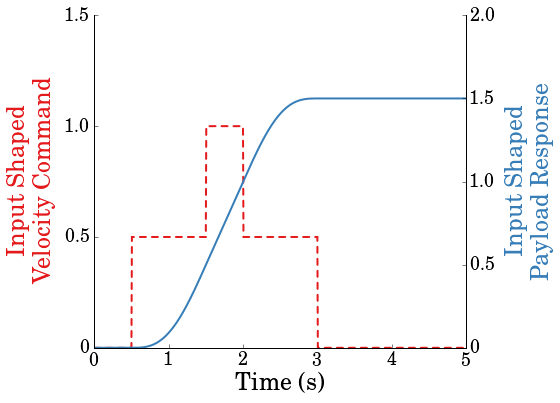

In [11]:
plt.rcParams['axes.grid'] = False # No grids for these dual y plots

# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax1 = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax1.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax1.get_xmajorticklabels(),family='serif',fontsize=18)
# ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# ax1.grid(True,linestyle=':',color='0.75')
ax1.set_axisbelow(True)

plt.xlabel('Time (s)',family='serif',fontsize=24,weight='bold',labelpad=5)
plt.ylabel('Input Shaped \nVelocity Command',family='serif',fontsize=24,color = '#e41a1c',weight='bold',labelpad=10)


# plot the response
ax1.plot(t,resp_shaped[:,3], linewidth=2, color = '#e41a1c', linestyle = '--', label=r'Command $(y)$')
plt.ylim(0,1.5)
plt.yticks([0,0.5,1,1.5],['0','0.5','1.0','1.5'])
plt.xticks([0,1,2,3,4,5],['0','1','2','3','4','5'])

ax2 = ax1.twinx()
ax2.spines['top'].set_color('none')
ax2.plot(t,resp_shaped[:,0], linewidth=2, color = '#377eb8', linestyle = '-', label=r'Response $(x)$')
plt.ylim(0,2)
plt.yticks([0,0.5,1,1.5,2.0],['0','0.5','1.0','1.5','2.0'])
plt.ylabel('Input Shaped \nPayload Response',family='serif', fontsize=24, color = '#377eb8',weight='bold',labelpad=10)

# leg = legend(loc='lower right', fancybox=True)
# ltext  = leg.get_texts() 
# setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('MassSpringDamper_ZVshapedVEL_Resp.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

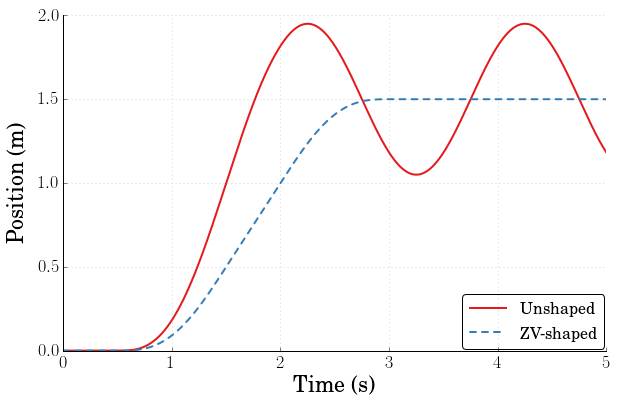

In [12]:
# Let's compare the shaped and unshaped directly

# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Position (m)',family='serif',fontsize=22,weight='bold',labelpad=10)

# plot the response
plt.plot(t,resp_unshaped[:,0], linewidth=2, linestyle = '-', label=r'Unshaped')
plt.plot(t,resp_shaped[:,0], linewidth=2, linestyle = '--', label=r'ZV-shaped')

leg = plt.legend(loc='lower right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('MassSpringDamper_Resp_Comparison.pdf')

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [31]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
import codecs
from IPython.core.display import HTML
css_file = '../styling/CRAWLAB_IPythonNotebook.css'
HTML(codecs.open(css_file, 'r', 'utf-8').read())